In [1]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

load_dotenv(override=True)

/workspaces/js-complexity-model/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
%load_ext autoreload
%autoreload 2

from utils.preprocess_code import sanitize_code
from utils.fetch_api import fetch_features

In [3]:
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [4]:
dataset = load_dataset("aslam-naseer/js-function-complexity", split="all")


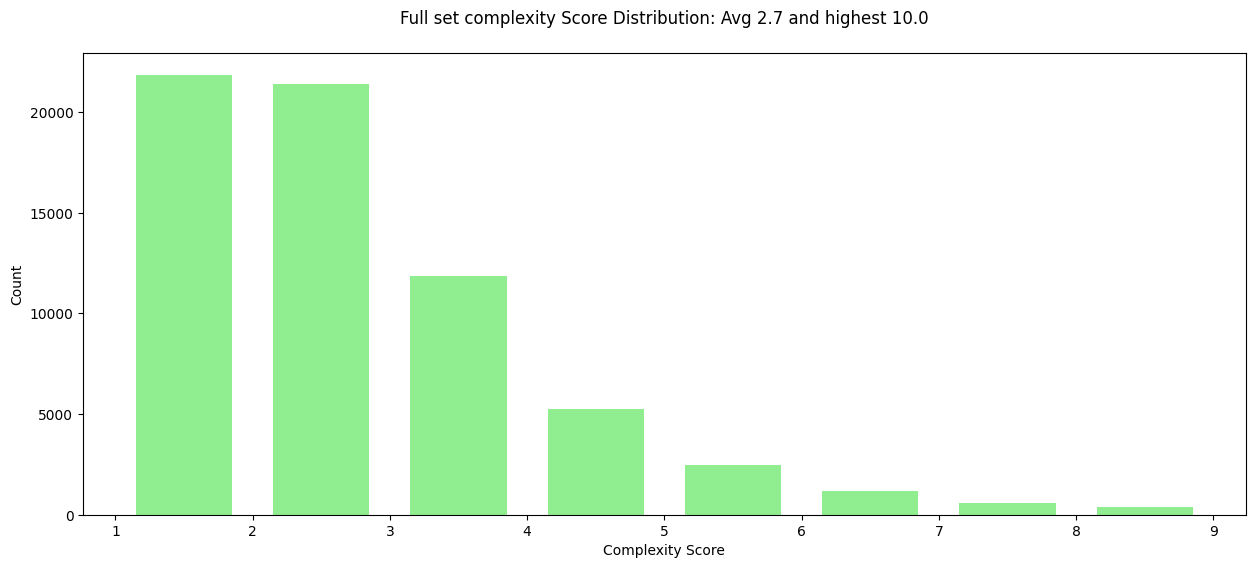

In [5]:
# Plot the distribution of complexity before splitting
scores = [example['complexity'] for example in dataset]


plt.figure(figsize=(15, 6))
plt.title(f"Full set complexity Score Distribution: Avg {sum(scores)/len(scores):,.1f} and highest {max(scores):,}\n")
plt.xlabel('Complexity Score')
plt.ylabel('Count')
plt.hist(scores, rwidth=0.7, color="lightgreen", bins=range(1,10))
plt.show()

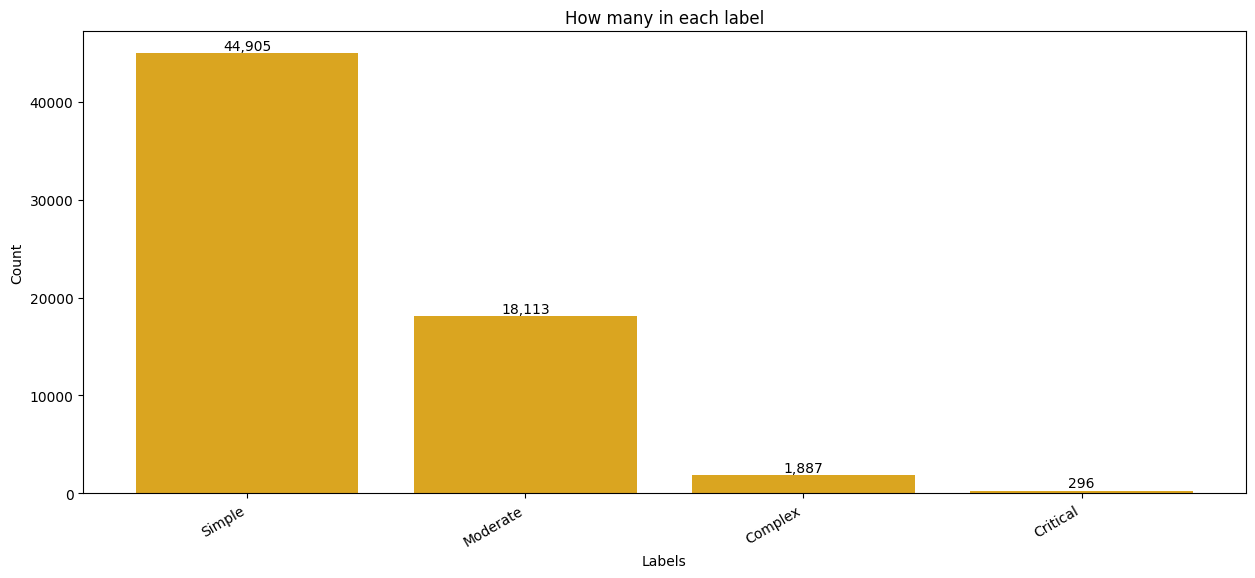

In [6]:
# Plot the distribution of labels before splitting
from collections import Counter

label_counts = Counter(dataset['label'])

labels = list(label_counts.keys())
counts = [label_counts[label] for label in labels]

plt.figure(figsize=(15, 6))
plt.bar(labels, counts, color="goldenrod")
plt.title('How many in each label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

## Shrink dataset to necessary size

In [7]:
np.random.seed(42)

SIZE = 6000

complexities = np.array([fn["complexity"] for fn in dataset], dtype=float)
p = (complexities - complexities.min()) / (complexities.max() - complexities.min() + 1e-9)

w = np.where(p < 0.025, p, p**3)
w = w / w.sum()
idx = np.random.choice(len(dataset), size=SIZE, replace=False, p=w)
sample = [dataset[i] for i in idx]

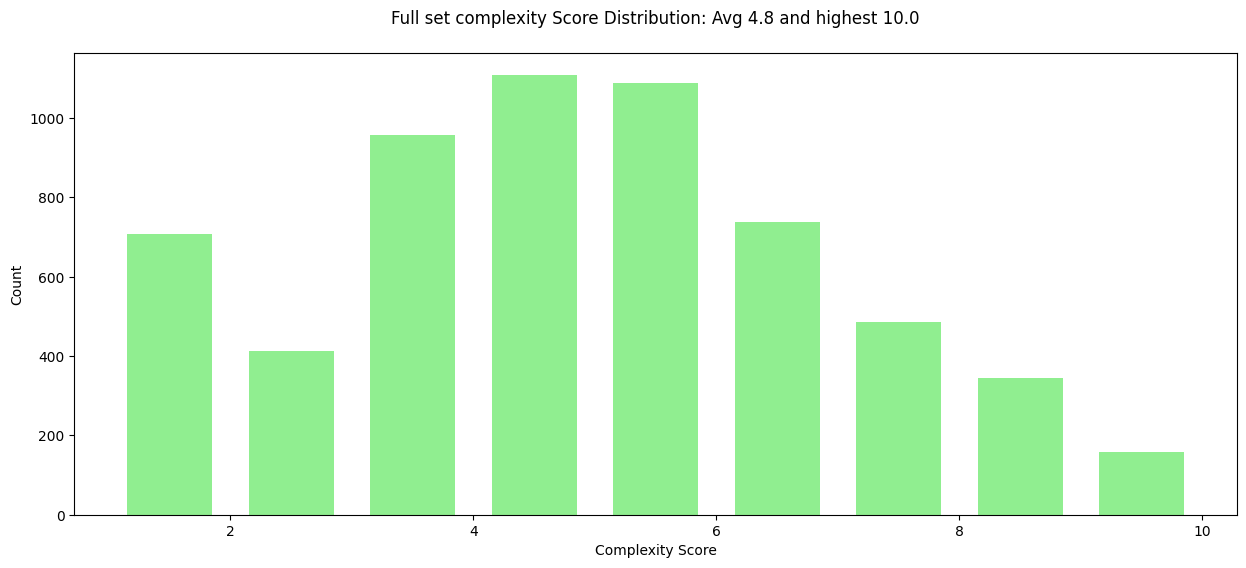

In [8]:
# Plot the distribution of complexity after splitting
scores = [example['complexity'] for example in sample]


plt.figure(figsize=(15, 6))
plt.title(f"Full set complexity Score Distribution: Avg {sum(scores)/len(scores):,.1f} and highest {max(scores):,}\n")
plt.xlabel('Complexity Score')
plt.ylabel('Count')
plt.hist(scores, rwidth=0.7, color="lightgreen", bins=range(1,11))
plt.show()

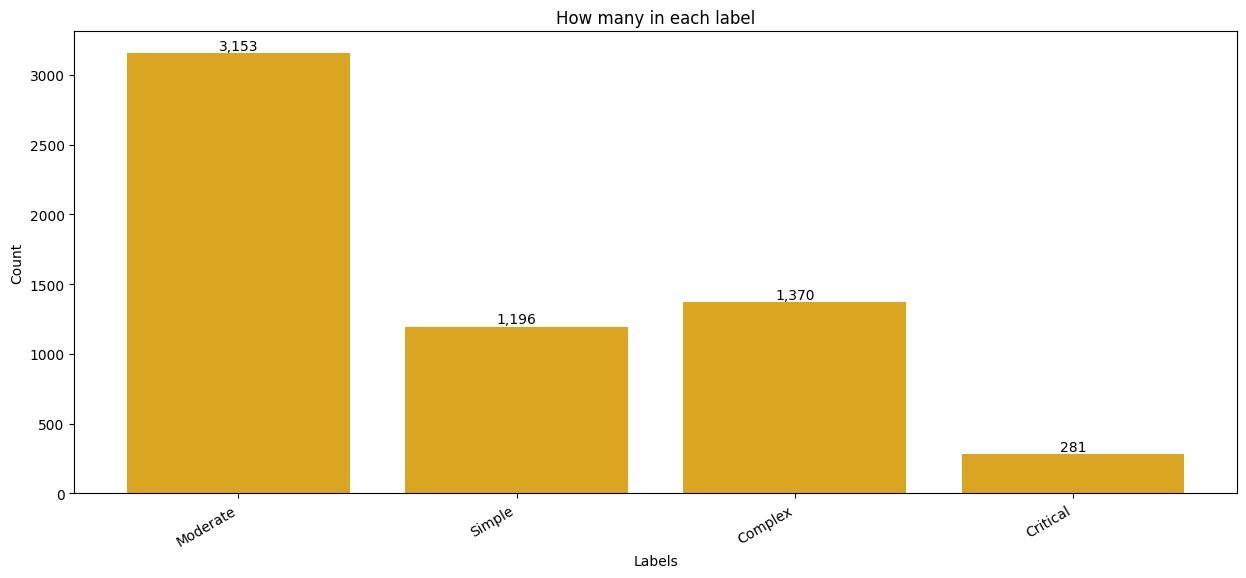

In [9]:
# Plot the distribution of labels after splitting
label_counts = Counter(fn['label'] for fn in sample)

labels = list(label_counts.keys())
counts = [label_counts[label] for label in labels]

plt.figure(figsize=(15, 6))
plt.bar(labels, counts, color="goldenrod")
plt.title('How many in each label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

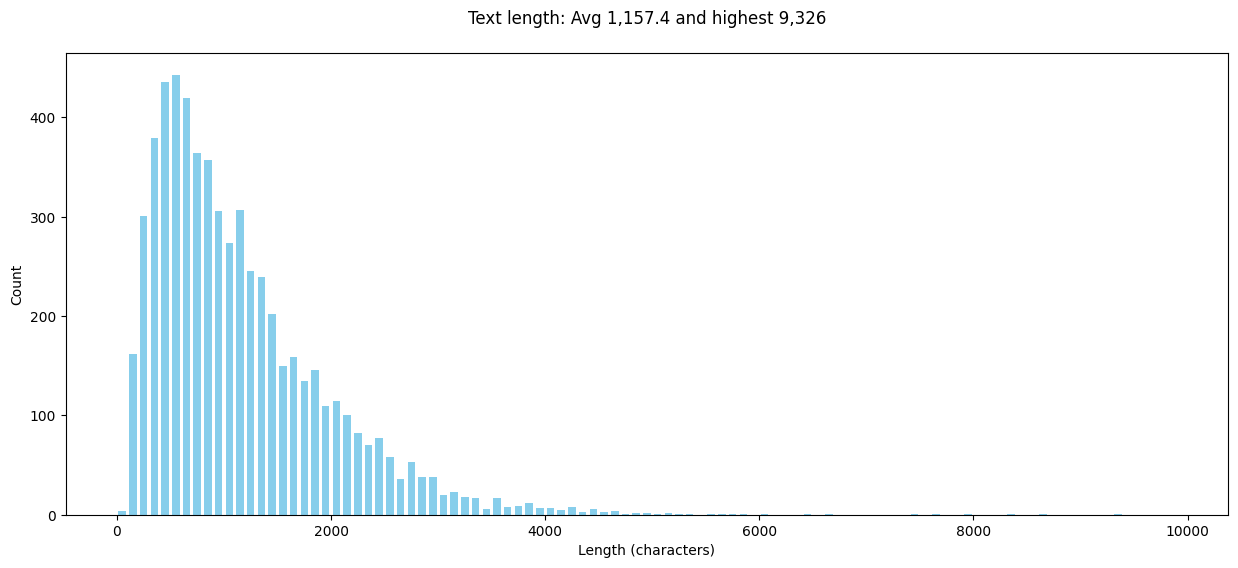

In [10]:
# Plot the distribution of lengths
lengths = [len(fn["code"]) for fn in sample]

plt.figure(figsize=(15, 6))
plt.title(f"Text length: Avg {sum(lengths)/len(lengths):,.1f} and highest {max(lengths):,}\n")
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="skyblue", bins=range(0, 10000, 100))
plt.show()

## Process the sample set

In [11]:
random.seed(42)
url = "http://172.17.0.1:8080/lint"
# url = "https://lintelli-backend.onrender.com/lint"

FEATURE_ORDER = [
  'parameter_count',
  'statement_count',
  'variable_count',
  'max_nesting_depth'
]

def process_datapoint(example):
    code = example.get("code", "")
    processed_code = sanitize_code(code)
    features = fetch_features(processed_code, url, False)

    if features is None:
        return {k: None for k in FEATURE_ORDER} | {"code": None}      
    
    return {
        "code": processed_code,
        "parameter_count": features.get("parameterCount"),
        "statement_count": features.get("statementCount"),
        "variable_count": features.get("variableCount"),
        "max_nesting_depth": features.get("maxNestingDepth"),
    }

# After mapping, filter using one of the new columns
sample_ds = Dataset.from_list(sample)
processed_dataset = sample_ds.map(process_datapoint, remove_columns=["repo"], num_proc=4)
processed_dataset = processed_dataset.filter(lambda x: x["code"] is not None)

print(f"Final dataset size: {len(processed_dataset)}")



Filter: 100%|██████████| 6000/6000 [00:00<00:00, 118177.70 examples/s]

Final dataset size: 5993


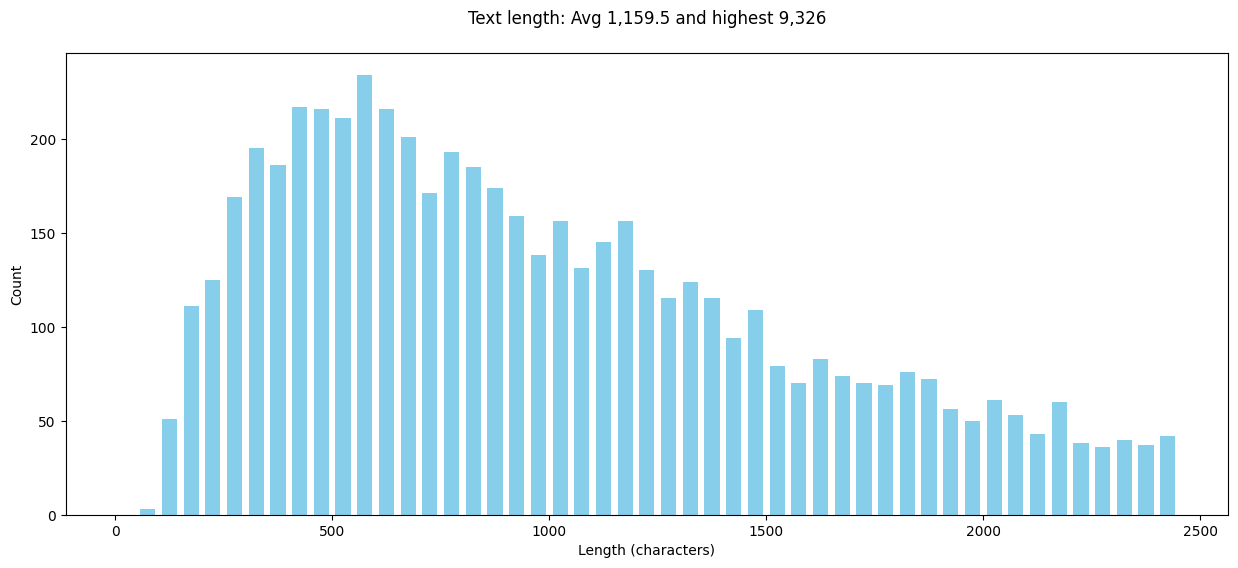

In [12]:
# Plot the distribution of lengths
lengths = [len(fn["code"]) for fn in processed_dataset]

plt.figure(figsize=(15, 6))
plt.title(f"Text length: Avg {sum(lengths)/len(lengths):,.1f} and highest {max(lengths):,}\n")
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="skyblue", bins=range(0, 2500, 50))
plt.show()

## Upload to HF 🤗

In [13]:
from datasets import DatasetDict
username = "aslam-naseer"
dataset_name = "js-function-complexity-processed"

shuffled_ds = processed_dataset.shuffle(seed=42)

val_ds = shuffled_ds.select(range(0, 500))
test_ds = shuffled_ds.select(range(500, 1000))
train_ds = shuffled_ds.select(range(1000, len(shuffled_ds)))

dataset_dict = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

print(f"Structure: {dataset_dict}")
dataset_dict.push_to_hub(f"{username}/{dataset_name}", private=False)

Structure: DatasetDict({
    train: Dataset({
        features: ['code', 'complexity', 'label', 'parameter_count', 'statement_count', 'variable_count', 'max_nesting_depth'],
        num_rows: 4993
    })
    validation: Dataset({
        features: ['code', 'complexity', 'label', 'parameter_count', 'statement_count', 'variable_count', 'max_nesting_depth'],
        num_rows: 500
    })
    test: Dataset({
        features: ['code', 'complexity', 'label', 'parameter_count', 'statement_count', 'variable_count', 'max_nesting_depth'],
        num_rows: 500
    })
})


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00,  5.57ba/s]
Processing Files (1 / 1): 100%|██████████| 2.54MB / 2.54MB,  529kB/s  
New Data Upload: 100%|██████████| 2.54MB / 2.54MB,  529kB/s  
Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 62.86ba/s]
Processing Files (1 / 1): 100%|██████████|  263kB /  263kB,  263kB/s  
New Data Upload: 100%|██████████|  263kB /  263kB,  263kB/s  
Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 67.95ba/s]
Processing Files (1 / 1): 100%|██████████|  270kB /  270kB,  225kB/s  
New Data Upload: 100%|██████████|  270kB /  270kB,  225kB/s  
Uploading the dataset shards: 100%|██████████| 1/1 [00:03<00:00,  3.46s/ shards]


CommitInfo(commit_url='https://huggingface.co/datasets/aslam-naseer/js-function-complexity-processed/commit/368bf02644be9b4694c8387c60e4a1437ee42e2f', commit_message='Upload dataset', commit_description='', oid='368bf02644be9b4694c8387c60e4a1437ee42e2f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/aslam-naseer/js-function-complexity-processed', endpoint='https://huggingface.co', repo_type='dataset', repo_id='aslam-naseer/js-function-complexity-processed'), pr_revision=None, pr_num=None)